# Predict House Price

In [ ]:
# Citation
Tran, C (2020). Kaggle House Price [Source code]. https://github.com/chriskhanhtran/kaggle-house-price/blob/master/ames-house-price.ipynb (2023)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


%matplotlib inline
sns.set_style('darkgrid')

In [ ]:
train_data = pd.read_csv('train.csv', index_col='Id')
test_data = pd.read_csv('test.csv', index_col='Id')

# Seperate dependent and independent variable
X_train = train_data.drop(['SalePrice'], axis=1)
y_train = train_data['SalePrice']

# Concatenate train and test data
X = pd.concat([X_train, test_data], axis=0)

In [ ]:
print("Train data : ", X_train.shape)
print("Test data : ", test_data.shape)

Train data :  (1460, 79)
Test data :  (1459, 79)


In [ ]:
numerical = [col for col in X_train.columns if X_train[col].dtype != 'object']
print(f"There are {len(numerical)} numerical variables:\n", numerical)
print('\n')
categorical = [col for col in X_train.columns if X_train[col].dtype == 'object']
print(f"There are {len(categorical)} categorical variables:\n", categorical)

There are 36 numerical variables:
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


There are 43 categorical variables:
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Function

# Exploratory Data Analysis

## 2.1 numerical variables

In [ ]:
import pandas as pd

# Filter numeric columns
numeric_cols = train_data.select_dtypes(include=[np.number]).columns
numeric_data = train_data[numeric_cols]

# Calculate correlation with 'SalePrice'
corr_mat = numeric_data.corrwith(train_data['SalePrice']).sort_values(ascending=False)
corr_mat.head(10)

,0
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


Using the [Recursive Features Elimination](https://link-url-here.org)
 (REF) with a linear regression seector I will select the top 10 variables that are significant.

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Initialize Linear Regression estimator
estimator = LinearRegression()

# Initialize RFE selector
rfe = RFE(estimator, n_features_to_select=10, step=1)

# Fit RFE selector to training data
rfe.fit(X_train.select_dtypes(exclude='object').fillna(0), y_train)

# Get selected features
selectedVar = list(X_train.select_dtypes(exclude='object').columns[rfe.support_])
selectedVar


['OverallQual',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars']

From the above analyses, I observe that **Overall Quality, GrLivArea, Number of Full Baths, Size of Garage and Year Built** are the most important variables in determining house price. Now lets explore them further

### OveralQual

Text(0.5, 1.0, 'House Price vs Overall Quality')

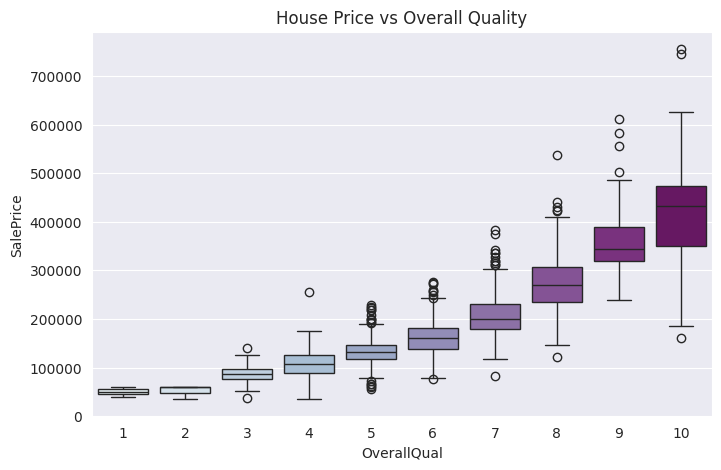

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='OverallQual', y='SalePrice', data=train_data, palette='BuPu')
plt.title('House Price vs Overall Quality')

### GrLivArea

<Figure size 800x500 with 0 Axes>

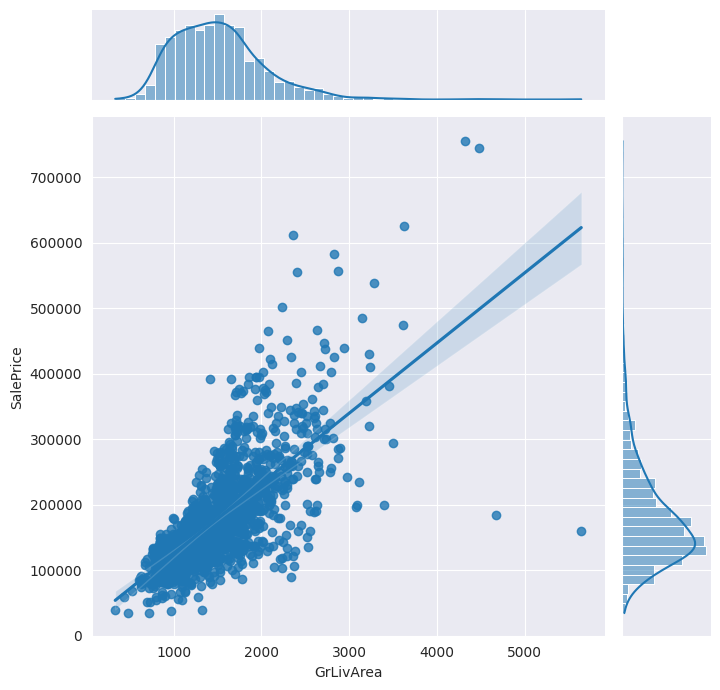

In [ ]:
plt.figure(figsize=(8, 5))
sns.jointplot(x='GrLivArea', y='SalePrice', data=train_data, kind='reg', height=7)
plt.show()

In [ ]:
correlation = train_data[['GrLivArea', 'SalePrice']].corr().iloc[1, 0]
print("Correlation: ", correlation)

Correlation:  0.7086244776126515


We can see that GrLivArea and SalePrice has linear relationship.There are also 2 outliers that have Living Area greater than 4000 but with price lower than $200000

### GarageCars

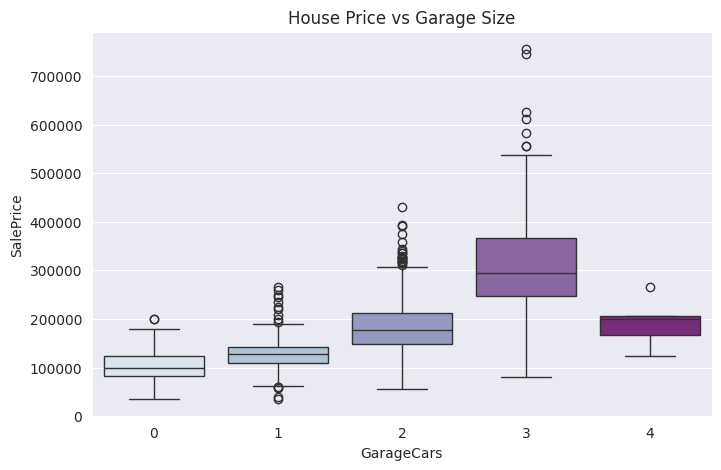

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='GarageCars', y='SalePrice', data=train_data, palette='BuPu')
title = plt.title('House Price vs Garage Size')

### YearBuilt

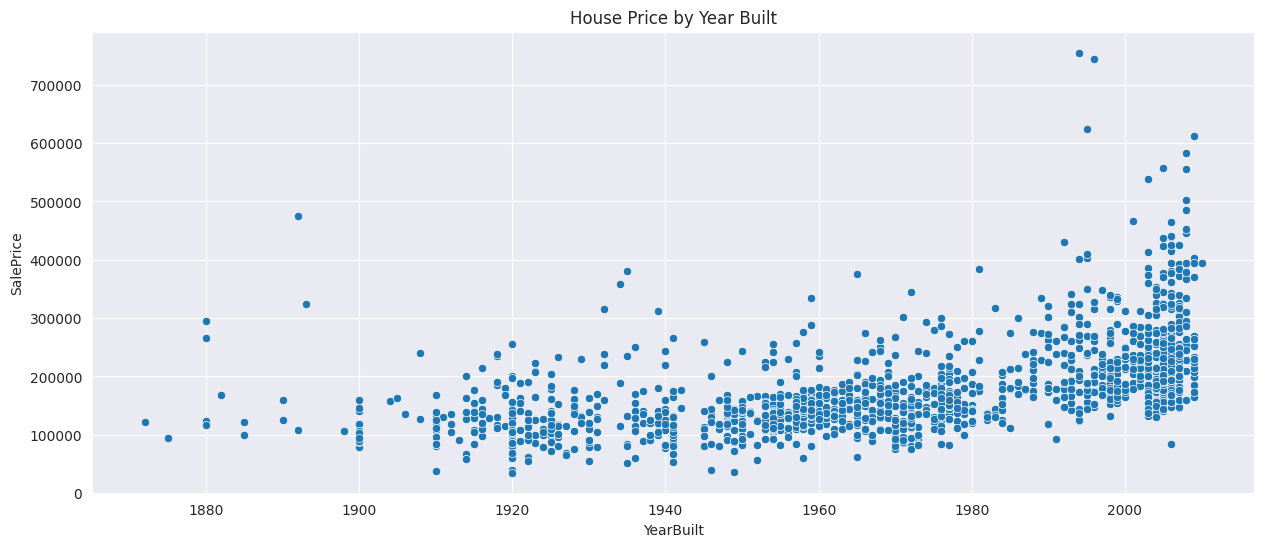

In [ ]:
plt.figure(figsize=(15, 6))
sns.scatterplot(x='YearBuilt', y='SalePrice', data=train_data)
title = plt.title('House Price by Year Built')

This is an interesting insights, house price and YearBuilt have a linear relationship. Newer houses have higher sale price than old houses. However, there are also some houses built before 1900 that have high prices.

## 2.2 Categorical Variables

I will focus specifically to this variable because I think they are significant

In [ ]:
sigCat = [
    'Street', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
    'Condition1', 'Condition2', 'RoofMatl', 'ExterQual', 'BsmtQual',
    'BsmtExposure', 'KitchenQual', 'Functional', 'GarageQual', 'PoolQC'
]

### neighborhood

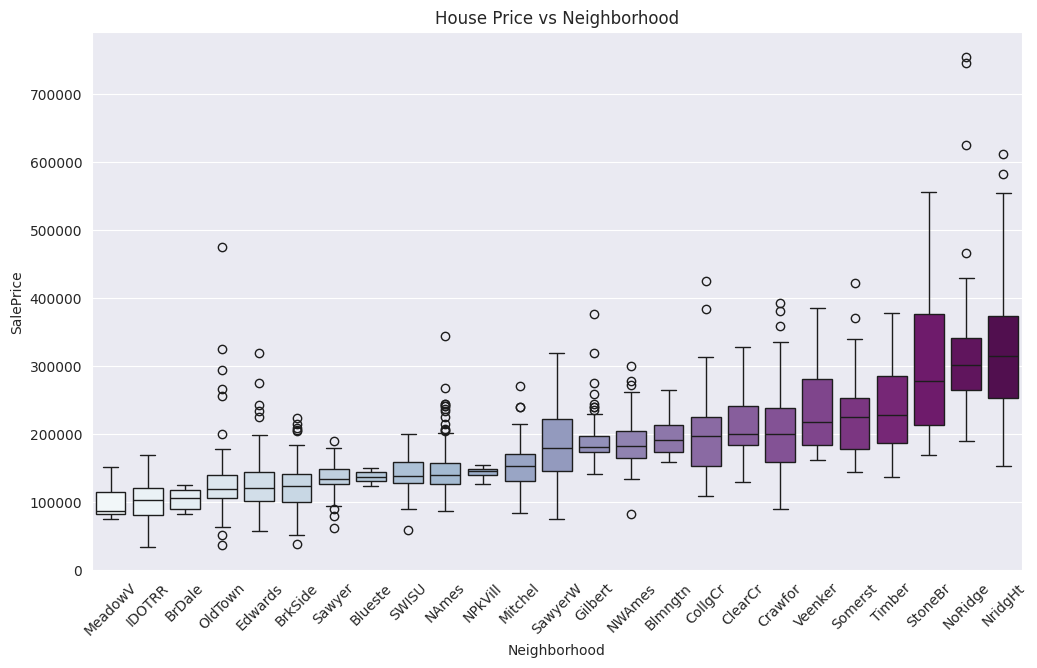

In [ ]:
# Create box plot
plt.figure(figsize=(12, 7))
sns.boxplot(x= 'Neighborhood',
            y='SalePrice',
            data=train_data,
            order = train_data.groupby('Neighborhood')['SalePrice'].median().sort_values().index,
            palette='BuPu')
title =plt.title('House Price vs Neighborhood')
tick =plt.xticks(rotation=45)

The top 3 most expensive neighborhoods are NridgHt, NoRidge and StoneBr with median house prices of approximately $300000, three times as high as the median of the 3 cheapest neighborhoods, which are BrDale, DOTRR and MeadowV.

### RoofMatl

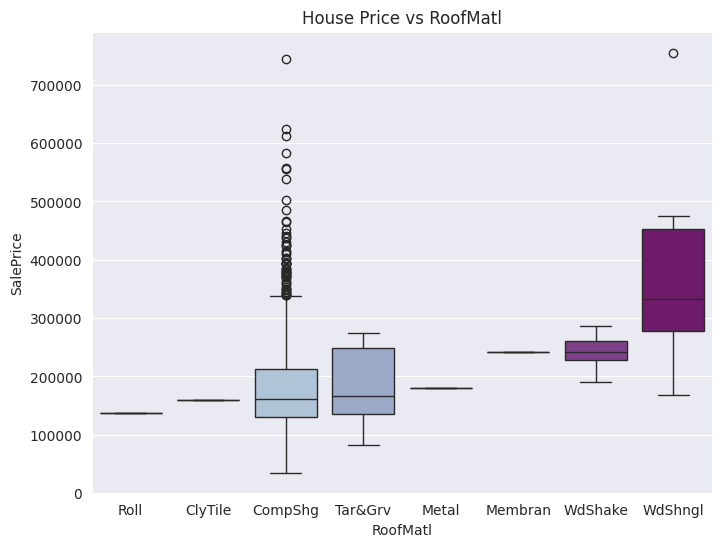

In [ ]:
# Create box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x= 'RoofMatl',
            y='SalePrice',
            data=train_data,
            order = train_data.groupby('RoofMatl')['SalePrice'].median().sort_values().index,
            palette='BuPu')
title =plt.title('House Price vs RoofMatl')

Houses using Wood Shingles roof are the most expensive with price ranging from $300000 to $450000.

 the average price difference between a house with a good kitchen and one with an excellent kitchen is about $120000.

## 2.3 Exporing Sale Price

<ipython-input-19-a3197273a48a>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train)


Skewness: 1.8828757597682129
Kurtosis: 6.536281860064529


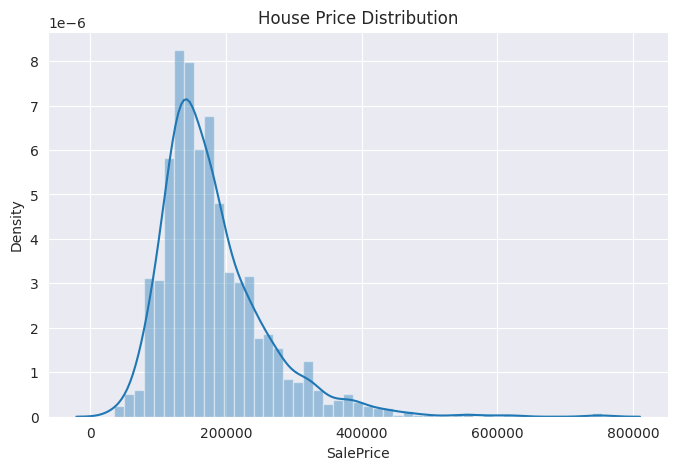

In [ ]:
plt.figure(figsize=(8,5))
sns.distplot(y_train)
plt.title("House Price Distribution")
print(f"""Skewness: {y_train.skew()}
Kurtosis: {y_train.kurt()}""")

Sale Price has a RIght-Skewed distribution with house prices ranging around $200000

## 2.4 Exporing Correlation

Text(0.5, 1.0, 'House PriceHeatmap')

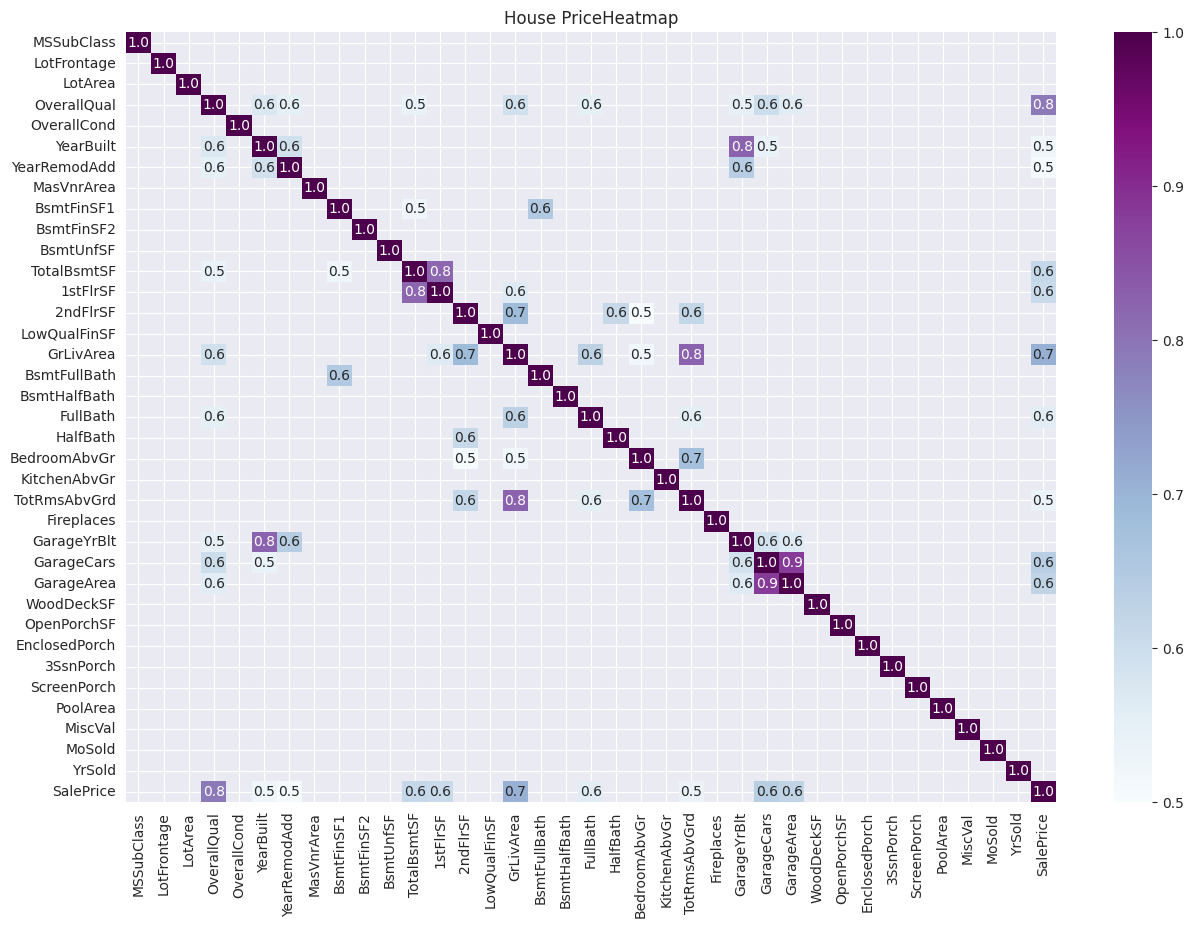

In [ ]:
cor_matrix = train_data[numeric_cols].corr()

# Filter out variables with correlations greater than 0.5
highcor_matrix = cor_matrix[abs(cor_matrix) >= 0.5]

# Heat Map
plt.figure(figsize=(15, 10))
sns.heatmap(highcor_matrix,
            annot=True,
            fmt='.1f',
            cmap='BuPu',
            vmin=0.5,
            vmax=1)
plt.title('House PriceHeatmap')

Here are the highly correlated variables

- GarageCars and GarageArea
- GarageYrBlt and YearBuilt
- 1stFlrSF and TotalBsmtSF
- GrLivArea and TotRmsAbvGrd

However, the data exhibits some multicollinearity, which will potenetially have negative impacts on our prediction models and makes standard errors of our estimates larger.
Therefore, for each pair of highly correlated features, I will remove a feature that has a lower correlation with SalePrice.

# Feature Engineering

## 3.1 Handling Missing Value

In [ ]:
missing_data_count = X.isnull().sum()
missing_data = pd.DataFrame({
    'Count': missing_data_count})

missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)
missing_data.head(10)

,Count
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
MasVnrType,1766
FireplaceQu,1420
LotFrontage,486
GarageFinish,159
GarageQual,159
GarageCond,159


In [ ]:
print(f"There are {len(missing_data)} variables having NaN value.\n")

There are 34 variables having NaN value.



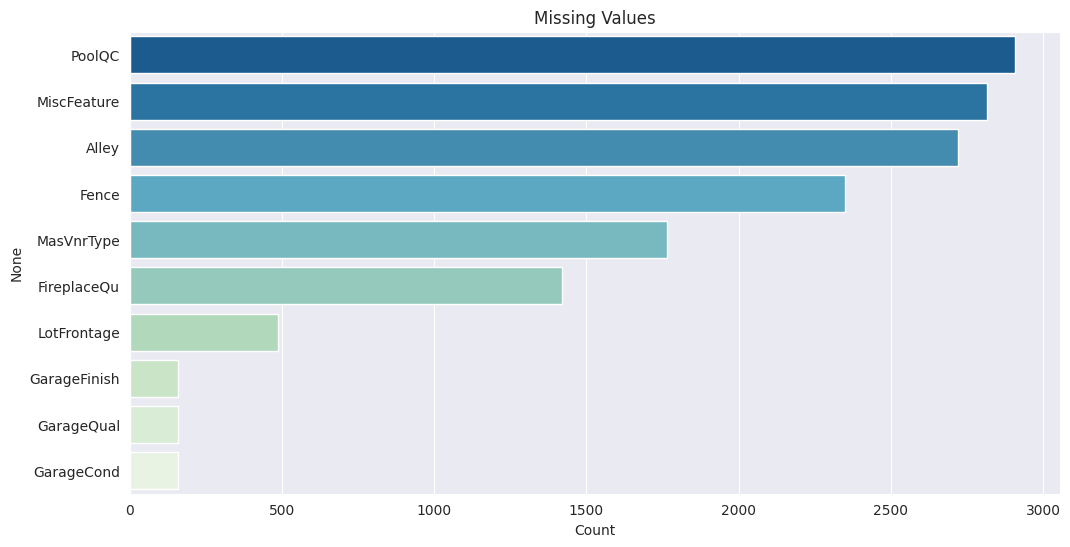

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(y=missing_data.head(10).index,
            x=missing_data.head(10).Count,
            palette='GnBu_r')
title = plt.title("Missing Values")


In this code snippet, I categorize the dataset features into three groups based on the nature of their missing values to apply appropriate imputation strategies:

- Group 1: Categorical features where missing values indicate the absence of a feature (e.g., no pool, no alley). These are filled with "None".

- Group 2: Numerical features where missing values are assumed to represent zero (e.g., no garage or basement area). These are filled with 0.

- Group 3: Categorical features where missing values likely imply a data entry issue. These are filled with the mode (most frequent value) of each respective column.

Additional handling includes imputing missing values in LotFrontage using the mean, and in GarageYrBlt using the values from YearBuilt, assuming they should align.

In [ ]:
from sklearn.impute import SimpleImputer
group_1 = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
X[group_1] = X[group_1].fillna("None")

group_2 = [
    'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]

X[group_2] = X[group_2].fillna(0)

group_3 = [
    'Functional', 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
    'Exterior2nd', 'SaleType', 'Utilities'
]

for col in group_3:
    mode_val = X[col].mode()[0]  # Get the mode (most frequent value) for each column
    X[col].fillna(mode_val, inplace=True)

X.LotFrontage = X.LotFrontage.fillna(X.LotFrontage.mean())
X.GarageYrBlt = X.GarageYrBlt.fillna(X.YearBuilt)

In [ ]:
sum(X.isnull().sum())

0

# Feature Engineering

## 3.2 Handling Outliers

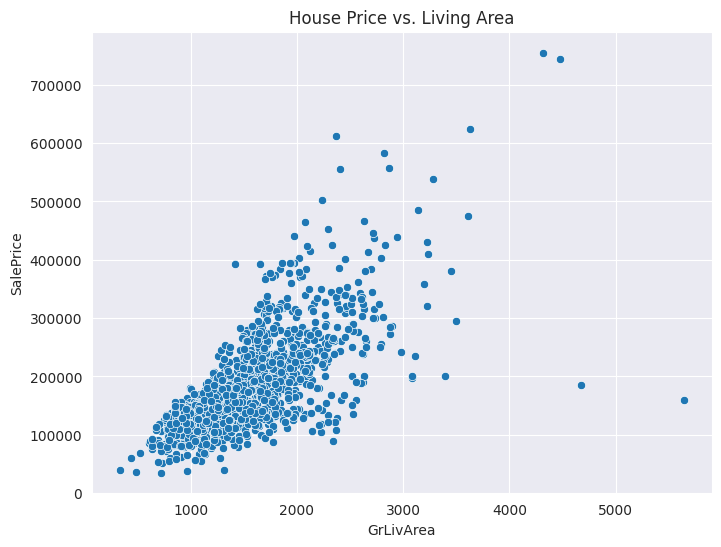

In [ ]:
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train_data)
title = plt.title('House Price vs. Living Area')

There is a house with Large living area but has a below-average price, which is clearly an outlier, therefore, I will remove it so that it will not affect our predictive model

In [ ]:
#outlier_idx = train_data[(train_data.GrLivArea > 4000) & (train_data.SalePrice < 200000)].index
#X.drop(outlier_idx, axis=0, inplace=True)
#y_train.drop(outlier_idx, axis=0, inplace=True)

outlier_idx = train_data[(train_data['GrLivArea'] > 4000) & (train_data['SalePrice'] < 200000)].index

# Filter outlier_idx to include only valid indices
outlier_idx = [idx for idx in outlier_idx if idx in X.index and idx in y_train.index]

# Drop rows with outlier indices from both X and y_train
X = X.drop(outlier_idx, axis=0)
y_train = y_train.drop(outlier_idx, axis=0)
train_data = train_data.drop(outlier_idx, axis=0)


## 3.3 New variables

It can be observed that the surface area of each floor has low correlation with house price; however, when we sum them up, the relationship becomes much stronger. Therefore, I will create a range variables below.

In [ ]:
# total square feet
X['totalSqFeet'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
# total bathrooms
X['totalBathroom'] = X.FullBath + X.BsmtFullBath + 0.5 * (X.HalfBath + X.BsmtHalfBath)
# age of the house
X['houseAge'] = X.YrSold - X.YearBuilt
# How new the house is relative to the time is was built
X['isNew'] = np.where(X.YrSold == X.YearBuilt, 1, 0)
# Is the house remodeled?
X['reModeled'] = np.where(X.YearRemodAdd == X.YearBuilt, 0, 1)


In [ ]:
X

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,MiscVal,MoSold,YrSold,SaleType,SaleCondition,totalSqFeet,totalBathroom,houseAge,isNew,reModeled
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,2,2008,WD,Normal,2566.0,3.5,5,0,0
2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,5,2007,WD,Normal,2524.0,2.5,31,0,0
3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,9,2008,WD,Normal,2706.0,3.5,7,0,1
4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,2,2006,WD,Abnorml,2473.0,2.0,91,0,1
5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,12,2008,WD,Normal,3343.0,3.5,8,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,None,Reg,Lvl,AllPub,Inside,...,0,6,2006,WD,Normal,1638.0,1.5,36,0,0
2916,160,RM,21.0,1894,Pave,None,Reg,Lvl,AllPub,Inside,...,0,4,2006,WD,Abnorml,1638.0,1.5,36,0,0
2917,20,RL,160.0,20000,Pave,None,Reg,Lvl,AllPub,Inside,...,0,9,2006,WD,Abnorml,2448.0,2.0,46,0,1


I will use One-Hot encoding for these below catgorical variables using LabelEncoder()
For numerical variables that without any ordinal meaning . I will also transform them into categorical variables.

In [ ]:
from sklearn.preprocessing import LabelEncoder

# categorical variables
encoder_vars = [
    "BsmtFinType1", "BsmtFinType2","BsmtQual", "ExterCond", "ExterQual", "FireplaceQu", "Functional",
    "GarageCond", "GarageQual","Alley", "BsmtCond", "BsmtExposure",  "HeatingQC", "KitchenQual", "LandSlope",
    "LotShape", "PavedDrive", "PoolQC", "Street", "Utilities"
]
label_encoder = LabelEncoder()
for var in encoder_vars:
    X[var] = label_encoder.fit_transform(X[var])


#Transform numerical variables
to_categorical = ['YrSold', 'MoSold', 'MSSubClass']

for col in to_categorical:
    X[col] = X[col].apply(str)

## 3.4 Normalizing Variables

Since linear regression relies on the assumption of normal distribution. Transfoming skewed data will help our models perform better.

Here I will examine our varaibles using Distribution plot and Q-Q plot.

In [ ]:
from scipy import stats
from scipy.stats import norm

# Write function to plot Distribution and QQ-plot
def norm_plot(X):

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    sns.distplot(X, fit=norm, ax=axes[0])
    axes[0].set_title('Distribution Plot')

    axes[1] = stats.probplot((X), plot=plt)
    plt.tight_layout()

<ipython-input-31-96273a5198b8>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, fit=norm, ax=axes[0])


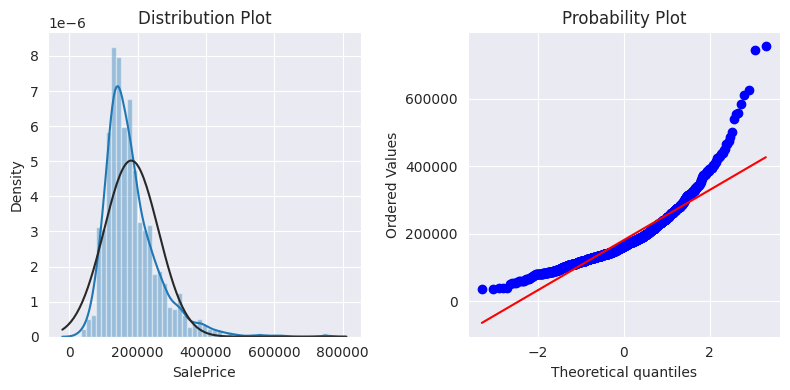

In [ ]:
norm_plot(y_train)

The data seems to be right-skewed, so I will use Log() to transform data.
Since nartural log of 0 is NaN, I will use Log(X+1)

<ipython-input-31-96273a5198b8>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, fit=norm, ax=axes[0])


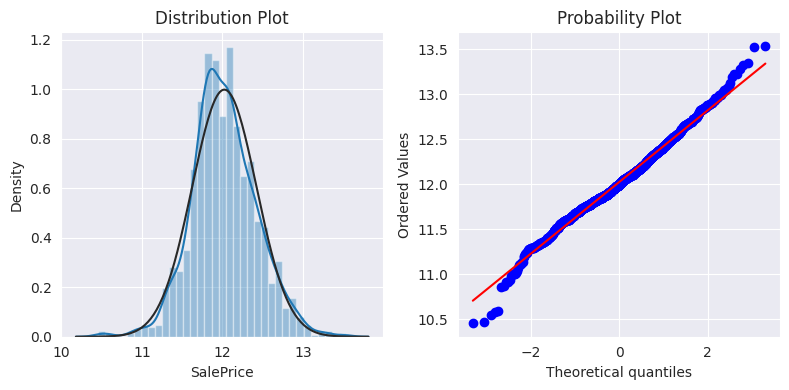

In [ ]:
y_train = np.log(1 + y_train)
norm_plot(y_train)

Now the distribution of the dependent variable is normal, I will examine other variables.
First I will rank the features based on their level of skewness

In [ ]:
skewness = train_data[numeric_cols].skew().sort_values(ascending=False)
skewness[abs(skewness) > 0.75]

,0
MiscVal,24.460085
PoolArea,15.948945
LotArea,12.573925
3SsnPorch,10.297106
LowQualFinSF,9.004955
KitchenAbvGr,4.484883
BsmtFinSF2,4.251925
ScreenPorch,4.118929
BsmtHalfBath,4.100114
EnclosedPorch,3.087164


In [ ]:
# Variable with high skewnwss
skewed = list(skewness[abs(skewness) > 0.5].index)

# Remove 'MSSubClass' and 'SalePrice'
skewed = [
    col for col in skewed if col not in ['MSSubClass', 'SalePrice']
]
for col in skewed:
    X[col] = np.log(1 + X[col])

<ipython-input-31-96273a5198b8>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(X, fit=norm, ax=axes[0])


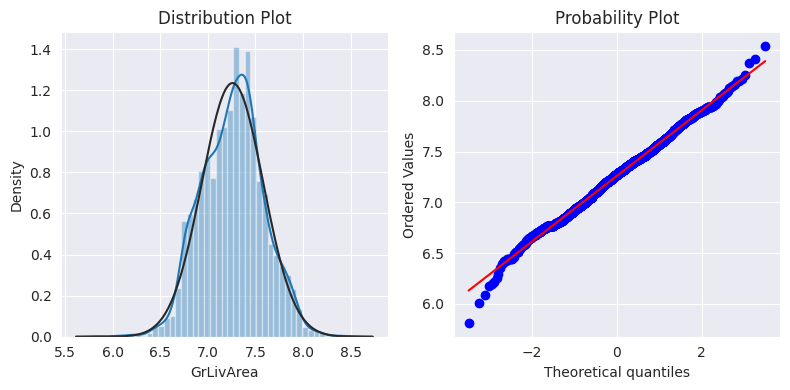

In [ ]:
norm_plot(X['GrLivArea'])

Looks good!

## 3.5 Scaling

In [ ]:
from sklearn.preprocessing import RobustScaler
num_cols = list(X.select_dtypes(exclude=['object']).columns)
scaler = RobustScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [ ]:
#One hot Encoding
X = pd.get_dummies(X, drop_first=True)

Now I will split X into a train and validation set to start modelling

In [ ]:
# splitting training and validation
len_test = len(test_data)
X_train = X.iloc[:-len_test, :]
X_test = X.iloc[-len_test:, :]
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)

X_train: (1458, 237)
X_test: (1459, 237)


# 4. Modeling

## Error Metrics

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

n_folds = 5

# write a function that calculate the train RMSLE
def getRMSE(model):
    kf = KFold(n_folds, shuffle=True, random_state=42)

    # Get RMSE score
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf))

    return rmse.mean()

## 4.1 Ridge Regression

In [ ]:
from sklearn.linear_model import Ridge, Lasso

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import RidgeCV

Ridge_predictor = RidgeCV(cv=30)
Ridge_predictor.fit(X_train,y_train)
print("Ridge Lambda: {0}".format(Ridge_predictor.alpha_))

Ridge Lambda: 10.0


Best lambda: 22.9
RMSLE: 0.11409306668450885


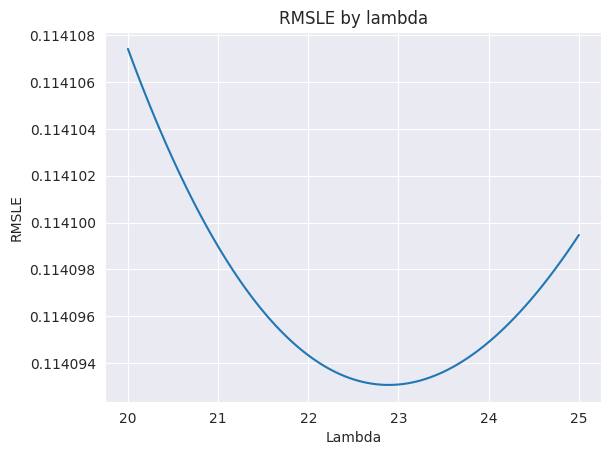

In [ ]:
lambda_list = list(np.linspace(20, 25, 101))

rmsle_ridge = [getRMSE(Ridge(alpha=lambda_)) for lambda_ in lambda_list]
rmsle_ridge = pd.Series(rmsle_ridge, index=lambda_list)

rmsle_ridge.plot(title="RMSLE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_ridge.idxmin())
print("RMSLE:", rmsle_ridge.min())

In [ ]:
ridge = Ridge(alpha=22.9)

## 4.2 Lasso Regression

In [ ]:
from sklearn import linear_model
from sklearn.linear_model import LassoCV

lasso_predictor = LassoCV(cv=10)
lasso_predictor.fit(X_train,y_train)
print("lasso Lambda: {0}".format(lasso_predictor.alpha_))

lasso Lambda: 0.0006022578672113934


Best lambda: 0.00065
RMSLE: 0.11335701677866225


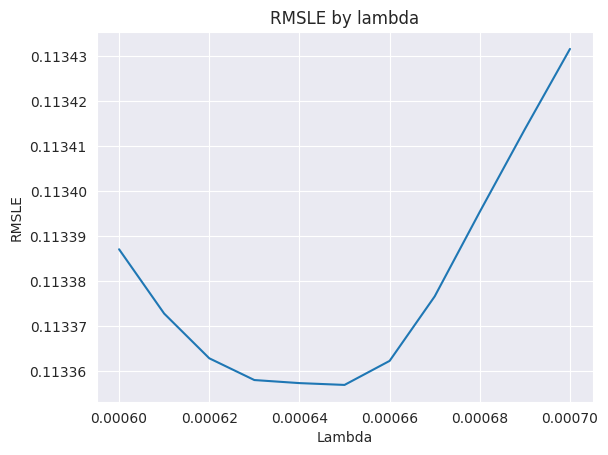

In [ ]:
lambda_list = list(np.linspace(0.0006, 0.0007, 11))
rmsle_lasso = [getRMSE(Lasso(alpha=lambda_, max_iter=100000)) for lambda_ in lambda_list]
rmsle_lasso = pd.Series(rmsle_lasso, index=lambda_list)

rmsle_lasso.plot(title="RMSLE by lambda")
plt.xlabel("Lambda")
plt.ylabel("RMSLE")

print("Best lambda:", rmsle_lasso.idxmin())
print("RMSLE:", rmsle_lasso.min())

In [ ]:
lasso = Lasso(alpha=0.0006)

## 4.3 XGBoost

Following this [guide](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?fbclid=IwAR1NTAXqgYzjOOFw3qOV5DrcItwNoM73iPvWggnuyVR1PbvORiEUjRunipo) of parameter tuning for XGBoost,

In [ ]:
from xgboost import XGBRegressor

In [ ]:
xgb = XGBRegressor(learning_rate=0.05,
                   n_estimators=2100,
                   max_depth=2,
                   min_child_weight=2,
                   gamma=0,
                   subsample=0.65,
                   colsample_bytree=0.46,
                   nthread=-1,
                   scale_pos_weight=1,
                   reg_alpha=0.464,
                   reg_lambda=0.8571,
                   silent=1,
                   random_state=7,
                   n_jobs=2)
getRMSE(xgb)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:16:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:16:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:16:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:16:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:16:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarn

0.11663215122930151

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:18:35] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


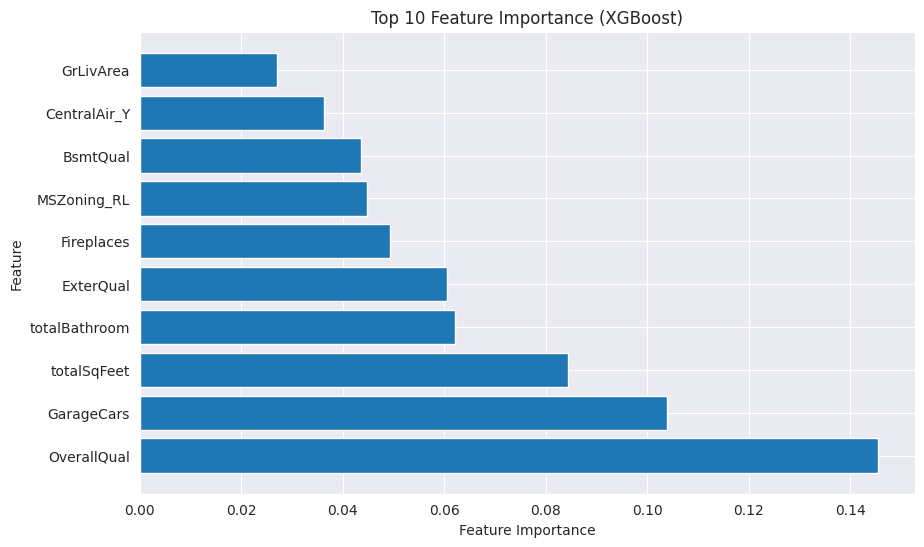

In [ ]:
xgb.fit(X_train, y_train)
# Assuming 'xgb' is your trained XGBoost model
xgb_feature_importance = xgb.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': xgb_feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Get the top 10 features
top_10_features = feature_importance_df.head(10)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance (XGBoost)')
plt.show()

## 4.4 LightGBM

LightGBM is a powerful gradient boosting framework based on decision tree algorithm. Like XGBoost, LightGBM has a high performance on large data sets  but much faster training speed than XGBoost does. Following this [guide](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/?fbclid=IwAR3uYr9U1VDaqh_jEn1cjvMyjEWVHKMaDm_Q9yD1y08OkGBywRR0qpuhhtw), I have tuned the parameters

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
lgbm = LGBMRegressor(objective='regression',
                    learning_rate=0.05,
                    n_estimators=730,
                    num_leaves=8,
                    min_data_in_leaf=4,
                    max_depth=3,
                    max_bin=55,
                    bagging_fraction=0.78,
                    bagging_freq=5,
                    feature_fraction=0.24,
                    feature_fraction_seed=9,
                    bagging_seed=9,
                    min_sum_hessian_in_leaf=11)
getRMSE(lgb)

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, 

0.11557040990859362

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, 

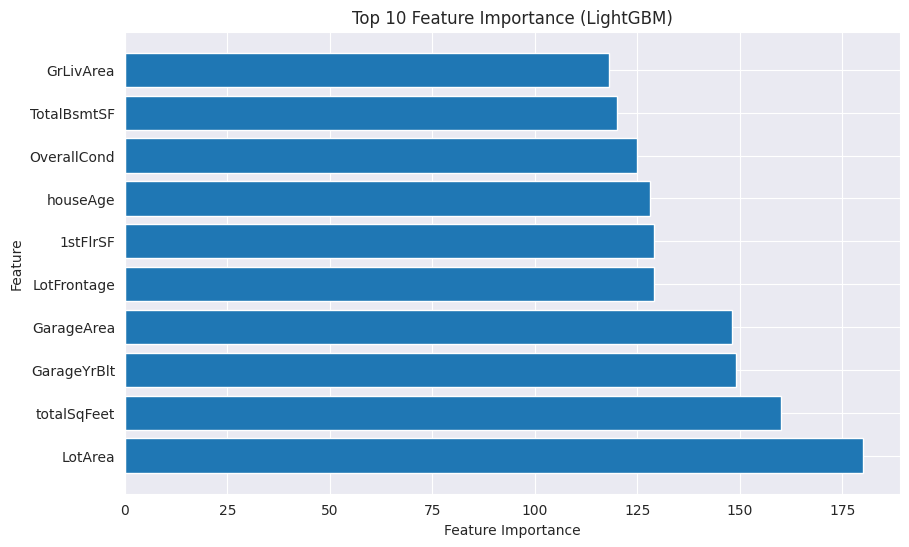

In [ ]:
lgbm.fit(X_train, y_train)
# Assuming 'xgb' is your trained XGBoost model
lgbm_feature_importance = lgbm.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': lgbm_feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Get the top 10 features
top_10_features = feature_importance_df.head(10)

# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importance (LightGBM)')
plt.show()

##Average Model

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone

class AvgModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models

    def fit(self, X, y):
        # clone models
        self.models_ = [clone(x) for x in self.models]

        # Train cloned models
        for model in self.models_:
            model.fit(X, y)

        return self

    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

In [ ]:
avg_model = AvgModel(models=(ridge, lasso,xgb,lgbm))
getRMSE(avg_model)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:20:44] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:20:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:20:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.621e-02, tolerance: 1.798e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:21:01] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, 

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:21:05] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, 

0.11057733694389746

In [ ]:
my_model = avg_model
my_model.fit(X_train, y_train)
predictions = my_model.predict(X_test)
final_predictions = np.exp(predictions) - 1

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [03:21:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.24
[LightGBM] [Warning] bagging_fraction is set=0.78, subsample=1.0 will be ignored. Current value: bagging_fraction=0.78
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=4, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=4
[LightGBM] [Warning] feature_fraction is set=0.24, 